In [1]:
import os
import numpy as np
from os.path import isfile, join
from os import listdir, path
import matplotlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import json
import cv2
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv2D, MaxPooling2D,AveragePooling2D, Flatten, BatchNormalization
from tensorflow.keras.optimizers import SGD, Adam, Adadelta

In [2]:
def configure_annotations(train_annotations_filename, val_annotations_filename):
    with open(train_annotations_filename) as f:
        train_annotations_filename = json.load(f)
    with open(val_annotations_filename) as f:
        val_annotations_filename = json.load(f)
    
    return train_annotations_filename, val_annotations_filename

In [3]:
train_annotations_filename, val_annotations_filename = configure_annotations('train_ann.json', 'validation_ann.json')

In [4]:
#Size size coeff for reduce training time (also I assume what we can convert coordinates back)
# note:
#  when I calculate and set width and height except points I got better accuracy
def congigure_box(box, size_coeff):
    width = box[2] - box[0]
    height = box[3] - box[1]
    box[2] = width
    box[3] = height
    
    box[0] *= size_coeff
    box[1] *= size_coeff
    box[2] *= size_coeff
    box[3] *= size_coeff
    return box

In [5]:
def transorm_image_to_zero_and_one(image):
        temp_image = np.copy(image)
        mean = np.mean(temp_image)
        std = np.std(temp_image)
        for i,r in enumerate(temp_image):
            for j,c in enumerate(r):
                if abs(c - mean) < std + (1/std + 2):
                    temp_image[i][j] = 0
                else:
                    temp_image[i][j] = 1
                    
        return temp_image

In [6]:
def get_train_dataset_and_val_dataset(dirName):
    image_names = listdir(dirName)
    train_X = []
    train_Y = []
    test_X = []
    test_Y = []
    for filename in image_names:
        if filename.endswith('.png'):
            image = mpimg.imread(path.join(os.getcwd() + "/rect_images/" + filename), cv2.CV_8U)
            size_coeff = 0.5
            gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
            new_size = (int(gray_image.shape[1] * size_coeff), int(gray_image.shape[0] * size_coeff))
            filtered_image = cv2.resize(gray_image, new_size)
            
            filtered_image = cv2.GaussianBlur(filtered_image,(5,5),0)
            filtered_image = transorm_image_to_zero_and_one(filtered_image)
#             filtered_image = cv2.Canny(filtered_image,0,1)
            
            for train_ann in train_annotations_filename:
                if train_ann['fname'] == filename:
                    box = train_ann['box']
                    box = congigure_box(box, size_coeff)
    
                    train_X.append(filtered_image)
                    train_Y.append(np.array(box, dtype=float))
                    
            for val_ann in val_annotations_filename:
                if val_ann['fname'] == filename:
                    box = val_ann['box']
                    box = congigure_box(box, size_coeff)
                    
                    test_X.append(filtered_image)
                    test_Y.append(np.array(box, dtype=float))
                    
    return np.array(train_X), np.array(train_Y), np.array(test_X), np.array(test_Y)

In [7]:
train_X, train_Y, test_X, test_Y = get_train_dataset_and_val_dataset("rect_images")

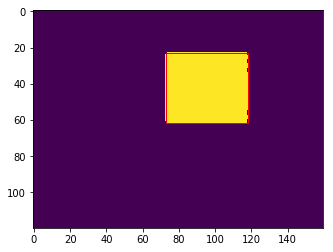

In [8]:
def draw_image_and_box(test_image, test_box):
    rect = matplotlib.patches.Rectangle((test_box[0],test_box[1]), test_box[2], test_box[3], linewidth=1,edgecolor='r',facecolor='none')
    plt.imshow(test_image)
    plt.gca().add_patch(rect)

test_index = 3
test_image, test_box = train_X[test_index], train_Y[test_index]
draw_image_and_box(test_image, test_box)


In [9]:
#Normalization step
# links for future:
# https://www.tensorflow.org/api_docs/python/tf/keras/utils/normalize
norm_train_X = (train_X - np.min(train_X)) / (np.max(train_X) - np.min(train_X))
norm_test_X = (test_X - np.min(test_X)) / (np.max(test_X) - np.min(test_X))
norm_train_Y = (train_Y - np.min(train_Y)) / (np.max(train_Y) - np.min(train_Y))
norm_test_Y = (test_Y - np.min(test_Y)) / (np.max(test_Y) - np.min(test_Y))

In [10]:
def addConvNormPoolDropLayer(model, channels, kernel_size, input_shape, max_pool, dropout):
    model.add(Conv2D(channels, kernel_size=kernel_size, activation='relu', input_shape = input_shape))
    model.add(BatchNormalization())
    if max_pool > 0:
            model.add(MaxPooling2D(max_pool))
    if dropout > 0:
        model.add(Dropout(0.2))

In [18]:
width = train_X[1].shape[1]
height = train_X[0].shape[0]

norm_train_X = norm_train_X.reshape(train_X.shape[0], height, width, 1)
norm_test_X = norm_test_X.reshape(test_X.shape[0], height, width, 1)
norm_train_Y = norm_train_Y.reshape(train_X.shape[0], 4)
norm_test_Y = norm_test_Y.reshape(test_X.shape[0], 4)

model = Sequential()
#add model layers
addConvNormPoolDropLayer(model, 16, 4, (height, width, 1), 3, 0)
addConvNormPoolDropLayer(model, 8, 4, (height, width, 1), 3, 0)
addConvNormPoolDropLayer(model, 4, 4, (height, width, 1), 4, 0.2)

model.add(Flatten())
model.add(Dense(50))
model.add(Dense(4))

#sgd stuck in minumun after 4 epochs to 100 (calculation not continued) val loss 0.0283 with 2 convlnormpoollayer
#adadelta - val loss after 150 epoch 0.066  with 2 convlnormpoollayer 
#adam 0.0052 -  with 2 convlnormpoollayer (with 3 layers same)
#RMSProp - 0.0289 stuck after 4 to 100 epochs  with 2 convlnormpoollayer with 3 layers 0.0062

#links for future:
# https://www.quora.com/What-are-differences-between-update-rules-like-AdaDelta-RMSProp-AdaGrad-and-AdaM
# https://www.youtube.com/watch?v=qAVZd6dHxPA
# http://www.bcl.hamilton.ie/~barak/papers/nips91-descent.pdf
model.compile('adam', 'mse')
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 117, 157, 16)      272       
_________________________________________________________________
batch_normalization_8 (Batch (None, 117, 157, 16)      64        
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 39, 52, 16)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 36, 49, 8)         2056      
_________________________________________________________________
batch_normalization_9 (Batch (None, 36, 49, 8)         32        
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 12, 16, 8)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 9, 13, 4)          516       
__________

In [19]:
history = model.fit(norm_train_X, norm_train_Y, epochs=50, shuffle=True, validation_data=(norm_test_X, norm_test_Y), verbose=2, batch_size=10)

Train on 2699 samples, validate on 301 samples
Epoch 1/50
 - 42s - loss: 0.7957 - val_loss: 0.0305
Epoch 2/50
 - 41s - loss: 0.0266 - val_loss: 0.0131
Epoch 3/50
 - 42s - loss: 0.0123 - val_loss: 0.0104
Epoch 4/50
 - 42s - loss: 0.0118 - val_loss: 0.0098
Epoch 5/50
 - 42s - loss: 0.0120 - val_loss: 0.0097
Epoch 6/50
 - 42s - loss: 0.0120 - val_loss: 0.0102
Epoch 7/50
 - 42s - loss: 0.0118 - val_loss: 0.0098
Epoch 8/50
 - 42s - loss: 0.0120 - val_loss: 0.0102
Epoch 9/50
 - 41s - loss: 0.0122 - val_loss: 0.0098
Epoch 10/50
 - 42s - loss: 0.0122 - val_loss: 0.0099
Epoch 11/50
 - 42s - loss: 0.0123 - val_loss: 0.0105
Epoch 12/50
 - 42s - loss: 0.0119 - val_loss: 0.0117
Epoch 13/50
 - 42s - loss: 0.0127 - val_loss: 0.0100
Epoch 14/50
 - 42s - loss: 0.0124 - val_loss: 0.0118
Epoch 15/50
 - 42s - loss: 0.0121 - val_loss: 0.0112
Epoch 16/50
 - 42s - loss: 0.0120 - val_loss: 0.0101
Epoch 17/50
 - 42s - loss: 0.0124 - val_loss: 0.0117
Epoch 18/50
 - 42s - loss: 0.0124 - val_loss: 0.0089
Epoch 19

['loss', 'val_loss']


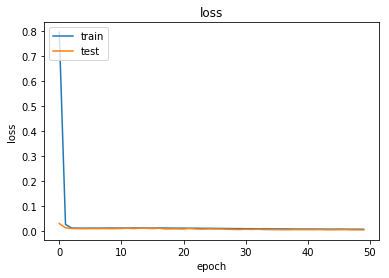

In [20]:
# summarize history for accuracy
# sgd plot (now )


# for the future: 
# make plots for all optimizers
print(history.history.keys())
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [21]:
pred_y = model.predict(norm_test_X)
denormalized_pred_y = pred_y * (np.max(test_Y) - np.min(test_Y)) + np.min(test_Y)
testIndex = 5
print(denormalized_pred_y[testIndex])
print(test_Y[testIndex])

[42.47129  61.385777 43.720715 22.198673]
[49.  65.  33.5 20. ]


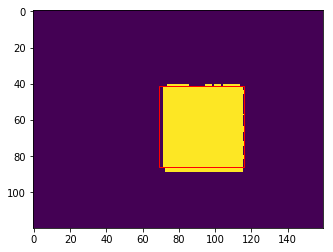

In [22]:
test_index = 12
test_image, test_box = test_X[test_index], denormalized_pred_y[test_index]
draw_image_and_box(test_image, test_box)

In [23]:
def IOU(bbox1, bbox2):
    print(bbox1)
    print(bbox2)


    x1, y1, w1, h1 = bbox1[0], bbox1[1], bbox1[2], bbox1[3]
    x2, y2, w2, h2 = bbox2[0], bbox2[1], bbox2[2], bbox2[3]

    w_I = min(x1 + w1, x2 + w2) - max(x1, x2)
    h_I = min(y1 + h1, y2 + h2) - max(y1, y2)
    if w_I <= 0 or h_I <= 0:
        return 0.
    I = w_I * h_I

    U = w1 * h1 + w2 * h2 - I

    return I / U


summed_IOU = 0.
for pred_bbox, test_bbox in zip(denormalized_pred_y.reshape(-1, 4), test_Y.reshape(-1, 4)):
    summed_IOU += IOU(pred_bbox, test_bbox)
    
    
print(summed_IOU / len(denormalized_pred_y))

[97.11863  26.167406 24.786053 19.519203]
[111.5  29.   43.    5. ]
[97.96344  29.763866 28.851942 34.164894]
[96.  35.  37.5 27. ]
[24.15796  51.60692  51.178635 21.229033]
[37.5 47.5 43.  10. ]
[26.19845  17.211458 40.998634 32.840794]
[26.   7.  40.5 40.5]
[42.490578 19.838404 43.696236 39.5667  ]
[41.  36.  47.5 35.5]
[42.47129  61.385777 43.720715 22.198673]
[49.  65.  33.5 20. ]
[15.768322 60.684227 19.939077 29.902857]
[ 5.5 72.5 18.  38. ]
[70.50552  47.82867  17.240913 25.754066]
[71.  66.5 43.  42. ]
[81.67097  60.527775 36.901745 28.258408]
[92.5 70.  42.  34. ]
[16.388046 27.021297 31.94565  23.873676]
[ 2.5 37.  46.5  5.5]
[121.946945  67.56264   13.491453  30.833302]
[118.5  68.5  13.5  32.5]
[34.497776 52.04132  48.43836  27.336437]
[46.  48.5 40.5 24.5]
[69.064156 41.277912 46.93079  44.918297]
[71.5 41.  45.  48. ]
[36.675182 67.077995 18.582005 26.03975 ]
[ 4.5 77.  17.   8.5]
[31.350319 32.159157 25.077374 26.896152]
[37.  39.5 16.5  7. ]
[117.20106   86.19484   20.3

In [ ]:
def plot_conv_weights(model, layer_index):
    W = model.get_layer(index=layer_index).get_weights()
    print(W[0])
#     print(W[1])
#     print(W[2])

In [ ]:
plot_conv_weights(model, 0)

# 